# Homework 2: SVD and PCA for Machine Learning (Part 3)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('./data/train.csv')
print(data.shape)
data = np.array(data)
X = data[:, 1:]
X = X.T

Y = data[:, 0]

print(X.shape, Y.shape)

X_cols, X_rows = X.shape

(42000, 785)
(784, 42000) (42000,)


In [14]:
C1 = 0
C2 = 6
C3 = 9
matrix_filter = (Y==C1) | (Y==C2) | (Y==C3)
filtered_X = X[:, matrix_filter]
filtered_Y = Y[matrix_filter]

In [15]:
num_samples = filtered_X.shape[1]
train_end = int(num_samples * 0.75)
X_train = filtered_X[:, :train_end]
X_test = filtered_X[:, train_end:]

y_train = filtered_Y[:train_end]
y_test = filtered_Y[train_end:]

In [ ]:
def compute_projected_matrix(X, k=2):
    centroid_X = np.mean(X, axis=1)
    centroid_X_column = np.reshape(centroid_X, (X_cols, 1))
    X_centered = X - centroid_X_column

    U, _, _ = np.linalg.svd(X_centered, full_matrices=False)
    Uk = U[:, :k]
    P = Uk.T

    Z = P @ X
    return Z, P

In [ ]:
Z_train, P = compute_projected_matrix(X_train)

print(Z_train.shape, X_train.shape)

Z1 = Z_train[:, y_train == C1]
Z2 = Z_train[:, y_train == C2]
Z3 = Z_train[:, y_train == C3]

cZ1 = np.mean(Z1, axis = 1)
cZ2 = np.mean(Z2, axis = 1)
cZ3 = np.mean(Z3, axis = 1)

pairs = [(cZ1, Z1), (cZ2, Z2), (cZ3, Z3)]


(2, 9342)
(2, 9342) (784, 9342)
(2,)


In [18]:
avg_distances = []
for c, Z in pairs :
    dist = []
    for i in range(Z.shape[1]):
        dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
    avg_distances.append(np.mean(np.array(dist)))

print(avg_distances)

[727.7249052041926, 538.5406033309062, 362.82208265596626]


The average distance from the centroid in a PCA-projected space essentially measures the spread or dispersion of the data around the centroid along the principal components. It essentially shows how the projection data contains the same variability of the original, uncompressed data. In addition, it shows if the clusters are well separated.

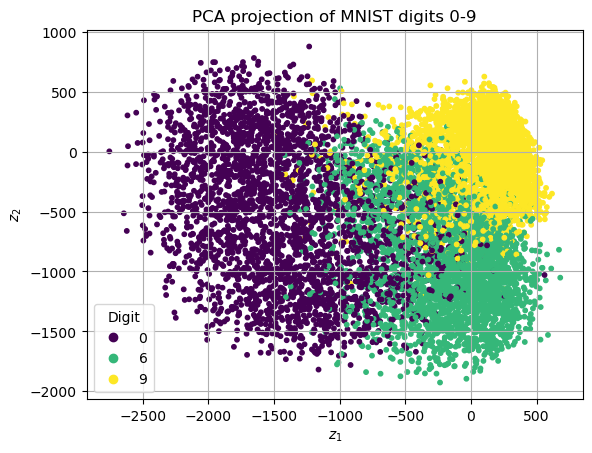

In [26]:
def visualize_clusters(Z_train, Y_train):
    ax = plt.scatter(Z_train[0, :], Z_train[1, :], c=Y_train, s=10)
    plt.legend(*ax.legend_elements(), title="Digit")
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_2$")
    plt.title("PCA projection of MNIST digits 0-9")
    plt.grid()
    plt.show()

visualize_clusters(Z_train, y_train)

### Using $P$ (i.e. $U_k$) on $X_{test}$

In [20]:
Z_test = P @ X_test

In [22]:
Z1_test = Z_test[:, y_test == C1]
Z2_test = Z_test[:, y_test == C2]
Z3_test = Z_test[:, y_test == C3]

pairs_test = [(cZ1, Z1_test), (cZ2, Z2_test), (cZ3, Z3_test)]

avg_distances_test = []
for c, Z in pairs_test :
    dist = []
    for i in range(Z.shape[1]):
        dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
    avg_distances_test.append(np.mean(np.array(dist)))

print(avg_distances_test)

[735.3144435828782, 533.9400884316509, 364.8136333660534]


The average distances are very close to the same found when using the centroid of $X_{test}$, meaning that the distribution of our data in the test set is very similar to the one found in the training set.

## PCA-based classifier

In [27]:
train_centroid = [cZ1, cZ2, cZ3]

def classify(x):
    dist = [np.linalg.norm(x - c) for c in train_centroid]
    labels = [C1, C2, C3]
    y_pred = labels[np.argmin(np.array(dist))]
    return y_pred

count = 0
for i in range(Z_test.shape[1]) :
    x = Z_test[:, i]
    y_pred = classify(x)
    count += (y_pred != y_test[i])

mr = (1/Z_test.shape[1])*count

print(f"Misclassification rate for the PCA-based classifier is {mr}")

Misclassification rate for the PCA-based classifier is 0.14895666131621188


[inserire quick commento qui]

In [37]:
def PCA_classifier(X, Y, labels, k=2):
    C1, C2, C3 = labels
    matrix_filter = (Y==C1) | (Y==C2) | (Y==C3)
    filtered_X = X[:, matrix_filter]
    filtered_Y = Y[matrix_filter]
    num_samples = filtered_X.shape[1]

    train_end = int(num_samples * 0.75)
    X_train = filtered_X[:, :train_end]
    X_test = filtered_X[:, train_end:]

    y_train = filtered_Y[:train_end]
    y_test = filtered_Y[train_end:]

    Z_train, P = compute_projected_matrix(X_train, k)

    Z1 = Z_train[:, y_train == C1]
    Z2 = Z_train[:, y_train == C2]
    Z3 = Z_train[:, y_train == C3]

    cZ1 = np.mean(Z1, axis = 1)
    cZ2 = np.mean(Z2, axis = 1)
    cZ3 = np.mean(Z3, axis = 1)

    pairs = [(cZ1, Z1), (cZ2, Z2), (cZ3, Z3)]

    avg_distances = []
    for c, Z in pairs :
        dist = []
        for i in range(Z.shape[1]):
            dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
        avg_distances.append(np.mean(np.array(dist)))

    print(f"Average distances from c_train on the training set: {avg_distances}")

    Z_test = P @ X_test

    Z1_test = Z_test[:, y_test == C1]
    Z2_test = Z_test[:, y_test == C2]
    Z3_test = Z_test[:, y_test == C3]

    pairs_test = [(cZ1, Z1_test), (cZ2, Z2_test), (cZ3, Z3_test)]

    avg_distances_test = []
    for c, Z in pairs_test :
        dist = []
        for i in range(Z.shape[1]):
            dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
        avg_distances_test.append(np.mean(np.array(dist)))

    print(f"Average distances from c_train on the testing set: {avg_distances_test}")

    train_centroid = [cZ1, cZ2, cZ3]

    def classify(x):
        dist = [np.linalg.norm(x - c) for c in train_centroid]
        labels = [C1, C2, C3]
        y_pred = labels[np.argmin(np.array(dist))]
        return y_pred

    count = 0
    for i in range(Z_test.shape[1]) :
        x = Z_test[:, i]
        y_pred = classify(x)
        count += (y_pred != y_test[i])

    mr = (1/Z_test.shape[1])*count

    print(f"Misclassification rate for the PCA-based classifier is {mr}")
    
    return avg_distances, avg_distances_test, mr


In [35]:
PCA_classifier(X, Y, (0,6,9))

(2, 9342)
Average distances from c_train on the training set: [727.7249052041926, 538.5406033309062, 362.82208265596626]
Average distances from c_train on the testing set: [735.3144435828782, 533.9400884316509, 364.8136333660534]
Misclassification rate for the PCA-based classifier is 0.14895666131621188


In [40]:
pairs = [(1,7,2), (2,5,9), (1,3,8), (3,6,9), (0,6,9)]
ks = [i for i in range(2,10)]

for k in ks :
    for labels in pairs:
        print(f'Using k={k} and labels {labels}')
        avg_distances, avg_distances_test, mr = PCA_classifier(X, Y, labels, k)
        print('\n')

Using k=2 and labels (1, 7, 2)
(2, 9946)
Average distances from c_train on the training set: [397.8879934643578, 440.00515035531174, 546.7505541897893]
Average distances from c_train on the testing set: [396.0453489697551, 432.84388717968983, 514.7287091698181]
Misclassification rate for the PCA-based classifier is 0.08504221954161639


Using k=2 and labels (2, 5, 9)
(2, 9120)
Average distances from c_train on the training set: [497.8789169072332, 582.1209281487997, 361.40722031331103]
Average distances from c_train on the testing set: [497.5862674219577, 583.3029941436959, 364.29869202078225]
Misclassification rate for the PCA-based classifier is 0.18355263157894736


Using k=2 and labels (1, 3, 8)
(2, 9823)
Average distances from c_train on the training set: [455.4716441069129, 559.7258384209626, 573.9718117035038]
Average distances from c_train on the testing set: [452.3785930241147, 567.5693116252457, 574.5039476964977]
Misclassification rate for the PCA-based classifier is 0.20458

inserire commento qui